<a href="https://colab.research.google.com/github/mdfirozwadud/alzheimers-detection-cnn/blob/main/Milestone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Milestone**-1

## Imports

In [1]:
import os
import shutil
import random
import zipfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# Google Colab Specific
from google.colab import files

print("All libraries imported successfully!")

All libraries imported successfully!


### **Download Dataset**
We are using the Dataset from the kaggle.
Here is the link: https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset


In [2]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d marcopinamonti/alzheimer-mri-4-classes-dataset

!unzip alzheimer-mri-4-classes-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (46).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (47).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (48).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (49).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (5).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (50).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (51).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (52).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (53).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (54).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemen

In [4]:
source_dir = '/content/dataset/Alzheimer_MRI_4_classes_dataset'
output_dir = '/content/split_dataset'

for cls in os.listdir(source_dir):
    cls_path = os.path.join(source_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.33, random_state=42)

    for split, imgs in [('train', train), ('val', val), ('test', test)]:
        dest = os.path.join(output_dir, split, cls)
        os.makedirs(dest, exist_ok=True)
        for img in imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(dest, img))

print("Dataset split complete (70% train, 20% val, 10% test)")

Dataset split complete (70% train, 20% val, 10% test)


## **Data Visualization Before Preprocessing**

In [5]:
train_dir = f'{output_dir}/train'
classes = sorted(os.listdir(train_dir))
counts = {s: {c: len(os.listdir(f'{output_dir}/{s}/{c}')) for c in classes}
          for s in ['train', 'val', 'test']}

### **Original Dataset: Image Distribution Across Train/Val/Test Splits**

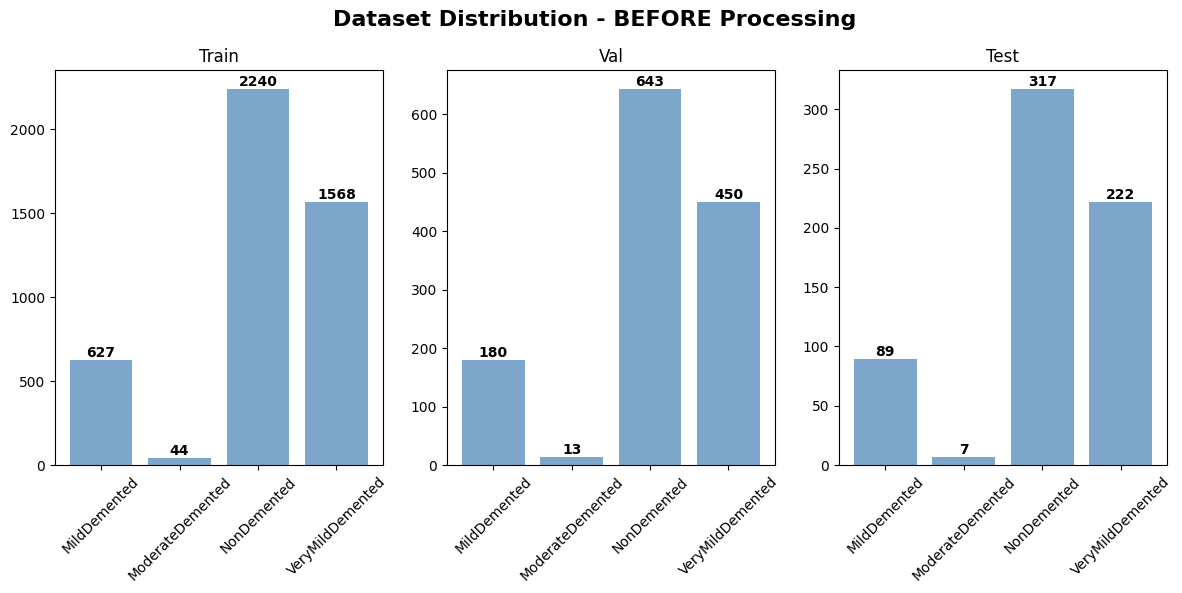

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle('Dataset Distribution - BEFORE Processing', fontsize=16, fontweight='bold')
for ax, (split, data) in zip(axes, counts.items()):
    bars = ax.bar(data.keys(), data.values(), color='steelblue', alpha=0.7)
    ax.set_title(split.capitalize(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h, int(h), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

### **Visual Inspection: Random Samples from Each Class (Original Images)**

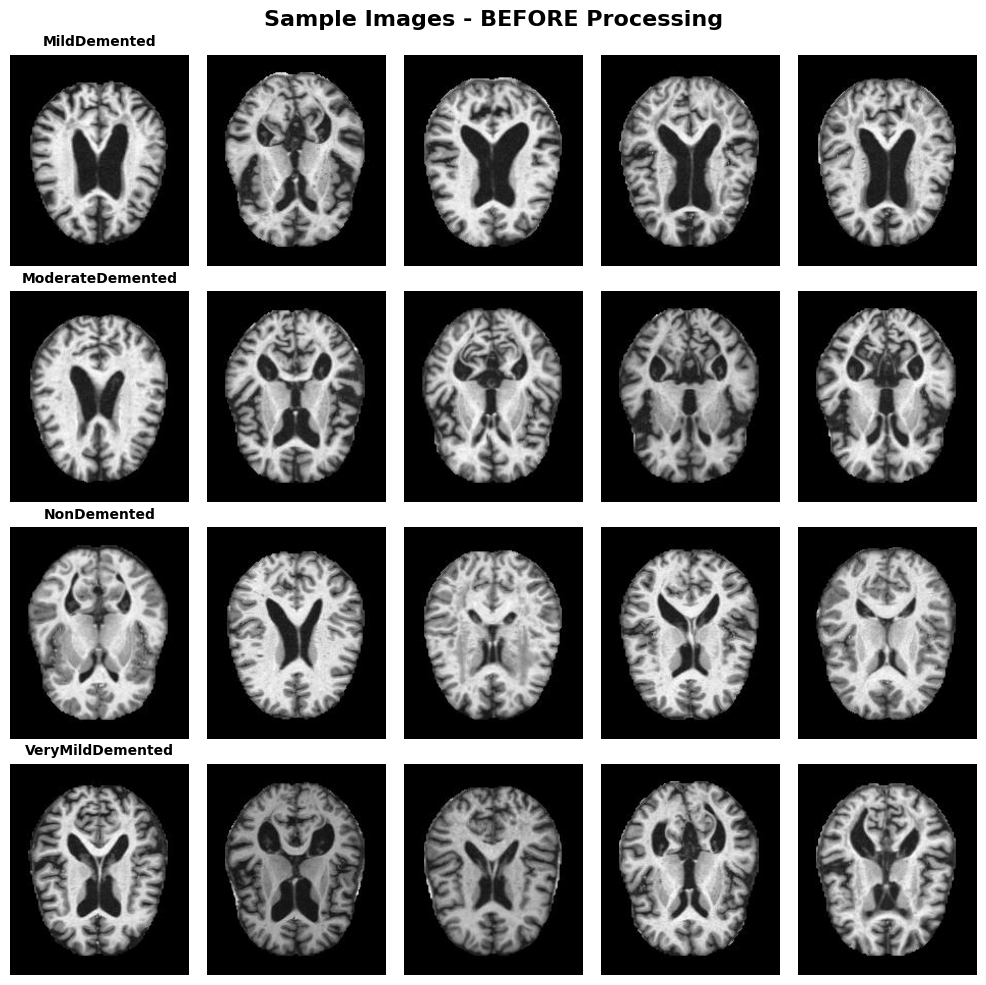

In [7]:
fig, axes = plt.subplots(len(classes), 5, figsize=(10, 10))
fig.suptitle('Sample Images - BEFORE Processing', fontsize=16, fontweight='bold')
for i, cls in enumerate(classes):
    imgs = random.sample(os.listdir(f'{train_dir}/{cls}'), min(5, len(os.listdir(f'{train_dir}/{cls}'))))
    for j, img in enumerate(imgs):
        axes[i, j].imshow(Image.open(f'{train_dir}/{cls}/{img}'), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(cls, fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

### **Class Balance Analysis: Distribution Across Splits (Before Processing)**

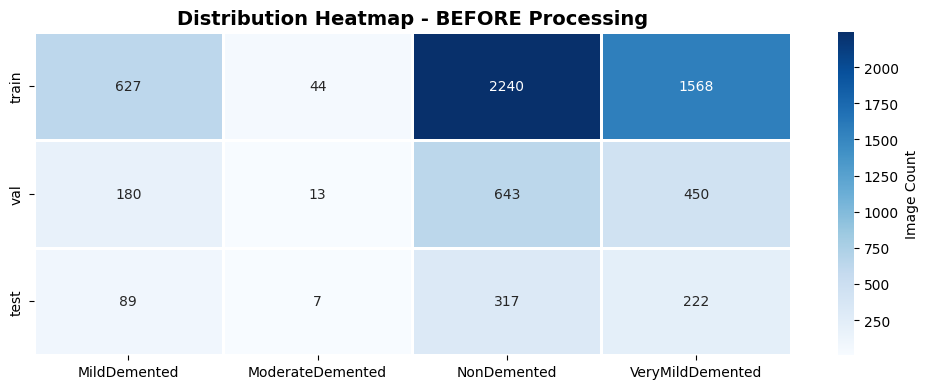

In [8]:
df = pd.DataFrame(counts).T
plt.figure(figsize=(10, 4))
sns.heatmap(df, annot=True, fmt='d', cmap='Blues', linewidths=1, cbar_kws={'label': 'Image Count'})
plt.title('Distribution Heatmap - BEFORE Processing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### **Dataset Summary Statistics**

In [9]:
print(f"Summary:")
print(f"Total: {df.sum().sum()} images")
print(f"Train: {df.loc['train'].sum()} | Val: {df.loc['val'].sum()} | Test: {df.loc['test'].sum()}")
print(f"Classes: {', '.join(classes)}")

Summary:
Total: 6400 images
Train: 4479 | Val: 1286 | Test: 635
Classes: MildDemented, ModerateDemented, NonDemented, VeryMildDemented


###**Download Split Dataset**

In [10]:
# zip_path = '/content/split_dataset.zip'
# with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, _, files_list in os.walk(output_dir):
#         for file in files_list:
#             file_path = os.path.join(root, file)
#             zipf.write(file_path, os.path.relpath(file_path, output_dir))

# print(f"Zip created: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")
# files.download(zip_path)
# print("Download started!")

# **Milestone-2**

## **Baseline Model**

### Efficient Loading of Data for Baseline Model

In [11]:
# Load data using ImageDataGenerator (no augmentation for baseline)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/content/split_dataset/train',
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

val_generator = datagen.flow_from_directory(
    '/content/split_dataset/val',
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    '/content/split_dataset/test',
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(train_generator.class_indices.keys())
print(f"Classes: {class_labels}")

Found 4479 images belonging to 4 classes.
Found 1286 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


### Extract Features

In [12]:
def extract_features(generator):
    """Extract flattened image features"""
    features = []
    labels = []

    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        # Flatten images: (batch, 176, 176, 3) → (batch, 92928)
        x_flat = x_batch.reshape(x_batch.shape[0], -1)
        features.append(x_flat)
        labels.append(y_batch)

    features = np.vstack(features)
    labels = np.vstack(labels)

    return features, np.argmax(labels, axis=1)

print("Extracting features from training set...")
X_train, y_train = extract_features(train_generator)
print(f"Training features shape: {X_train.shape}")

print("Extracting features from validation set...")
X_val, y_val = extract_features(val_generator)
print(f"Validation features shape: {X_val.shape}")

print("Extracting features from test set...")
X_test, y_test = extract_features(test_generator)
print(f"Test features shape: {X_test.shape}")

Extracting features from training set...
Training features shape: (4479, 92928)
Extracting features from validation set...
Validation features shape: (1286, 92928)
Extracting features from test set...
Test features shape: (635, 92928)


### Feature Scaling

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


### Training Baseline Model

In [14]:
print("\nTraining Logistic Regression (Baseline Model)...")
baseline_model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42,
    verbose=1
)

baseline_model.fit(X_train_scaled, y_train)
print("Baseline model training complete!")


Training Logistic Regression (Baseline Model)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline model training complete!


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


### Evaluate on Validation Set

In [15]:
y_val_pred = baseline_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_labels))


Validation Accuracy: 0.9199

Validation Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.84      0.89      0.87       180
ModerateDemented       0.79      0.85      0.81        13
     NonDemented       0.95      0.93      0.94       643
VeryMildDemented       0.92      0.91      0.92       450

        accuracy                           0.92      1286
       macro avg       0.87      0.90      0.88      1286
    weighted avg       0.92      0.92      0.92      1286



### Evaluation on Test Set

In [16]:
y_test_pred = baseline_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_labels))


Test Accuracy: 0.9244

Test Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.87      0.89      0.88        89
ModerateDemented       0.78      1.00      0.88         7
     NonDemented       0.94      0.95      0.95       317
VeryMildDemented       0.93      0.90      0.91       222

        accuracy                           0.92       635
       macro avg       0.88      0.93      0.90       635
    weighted avg       0.93      0.92      0.92       635



### Confusion Matrix

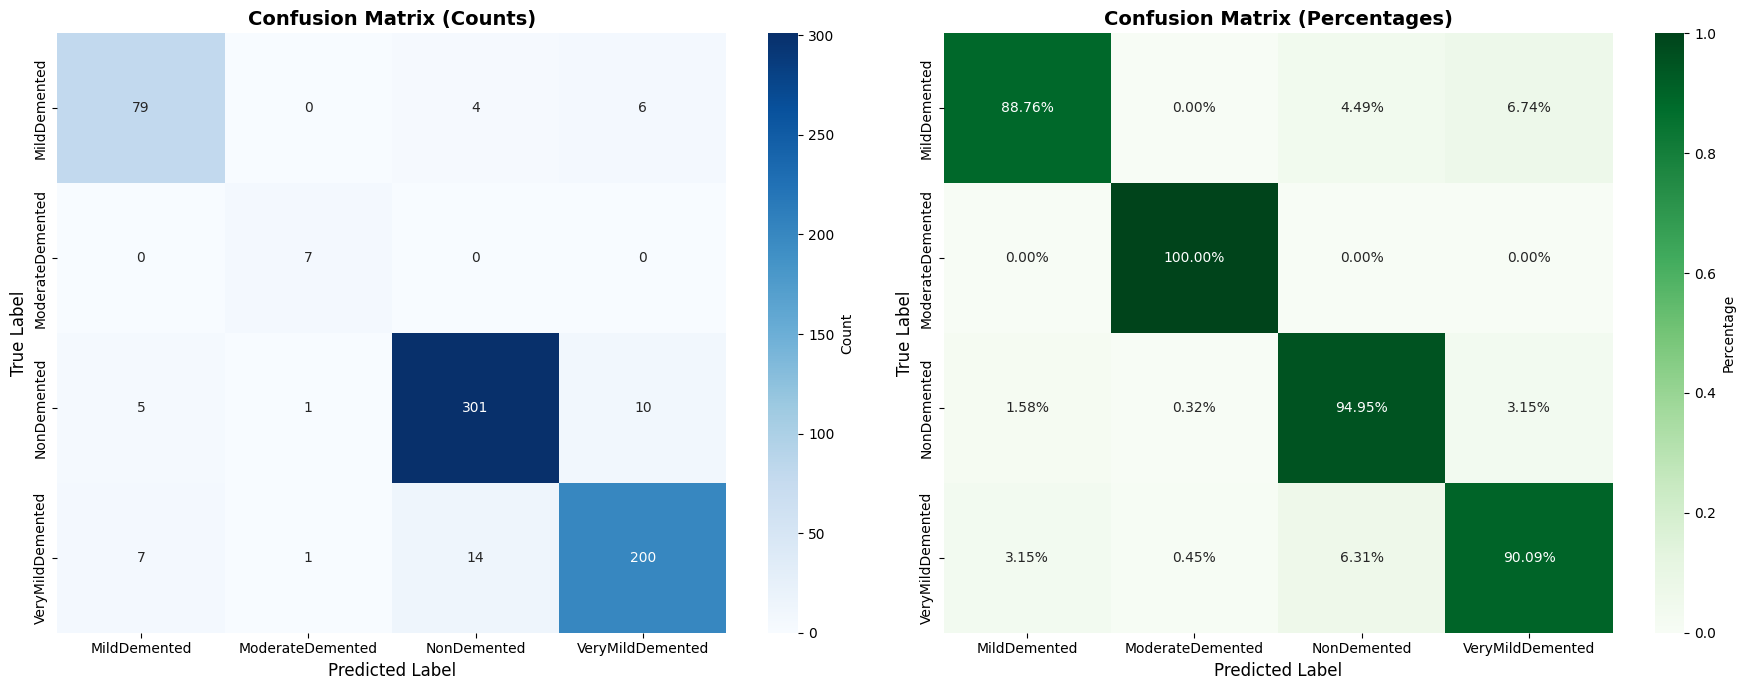

In [18]:
# Calculate normalized confusion matrix (row-wise percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Original counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels, ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized percentages
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_labels,
            yticklabels=class_labels, ax=axes[1],
            cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('/content/baseline_cm_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

### ROC Curve

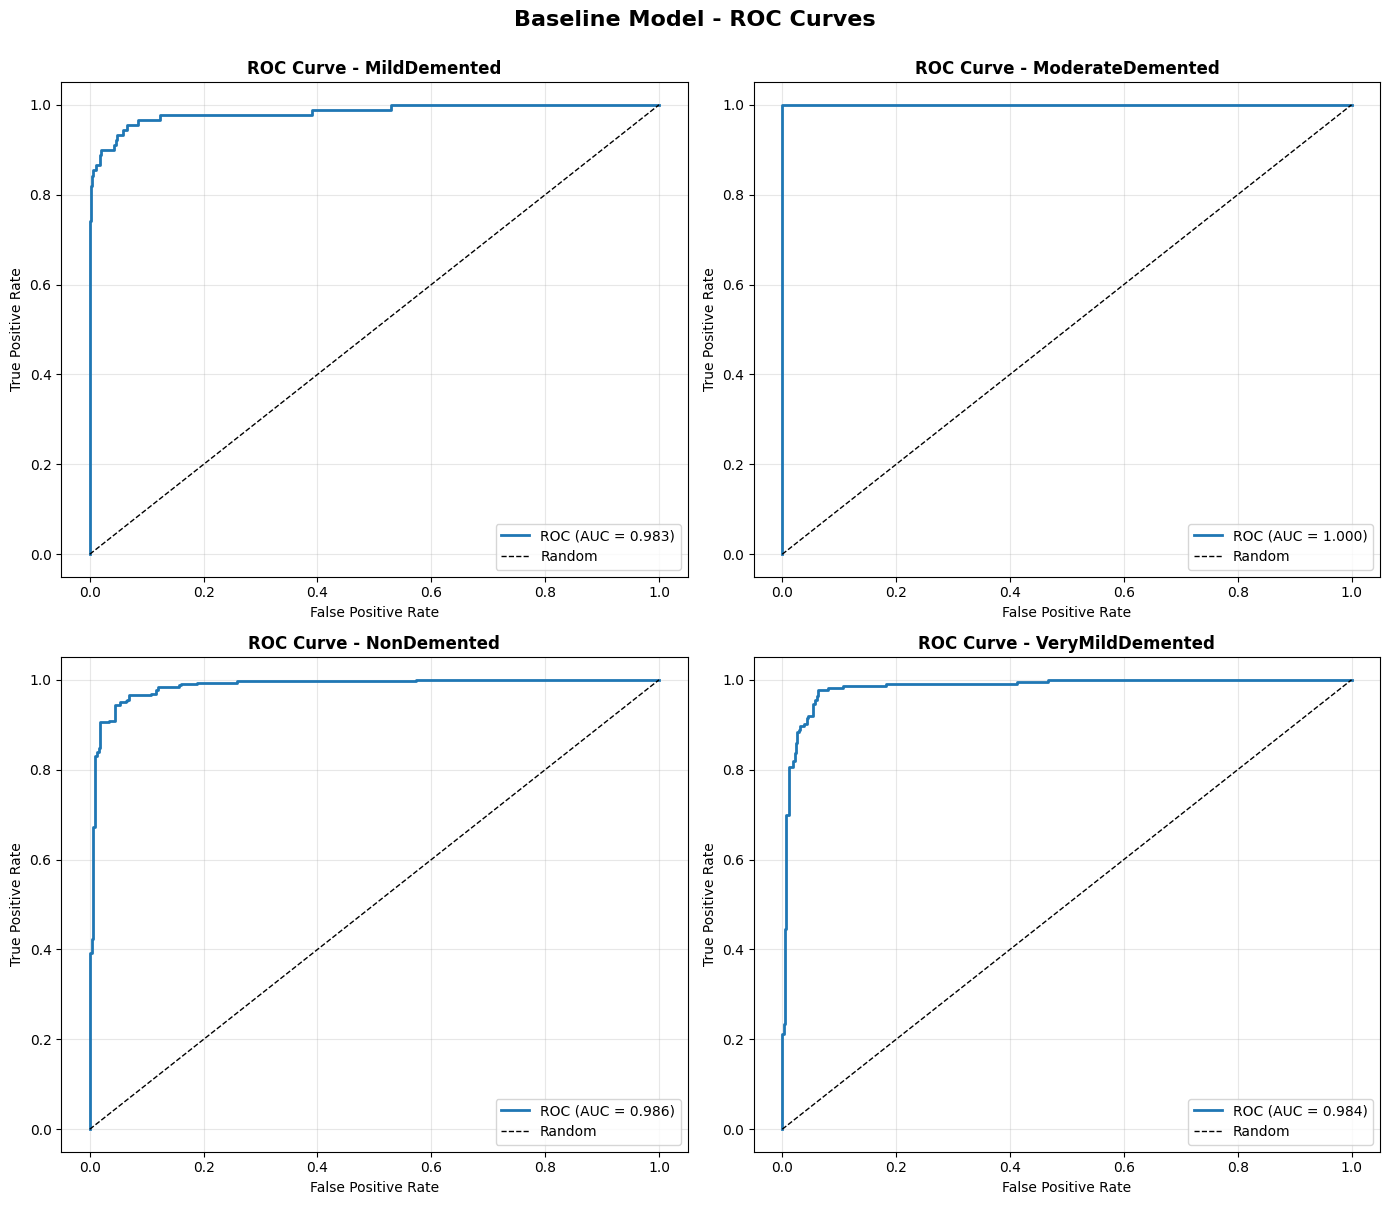

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get probability predictions
y_test_proba = baseline_model.predict_proba(X_test_scaled)

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(class_labels)))

# Plot ROC curve for each class
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)

    axes[i].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[i].set_xlabel('False Positive Rate', fontsize=10)
    axes[i].set_ylabel('True Positive Rate', fontsize=10)
    axes[i].set_title(f'ROC Curve - {class_name}', fontsize=12, fontweight='bold')
    axes[i].legend(loc='lower right')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Baseline Model - ROC Curves', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('/content/baseline_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Save Baseline Model

In [21]:
with open('/content/baseline_model.pkl', 'wb') as f:
    pickle.dump(baseline_model, f)

with open('/content/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nBaseline model and scaler saved!")


Baseline model and scaler saved!


### Summary

In [22]:
print("\n" + "="*60)
print("BASELINE MODEL SUMMARY")
print("="*60)
print(f"Model: Logistic Regression")
print(f"Features: Flattened images (176x176x3 = 92,928 features)")
print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_test)}")
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("="*60)


BASELINE MODEL SUMMARY
Model: Logistic Regression
Features: Flattened images (176x176x3 = 92,928 features)
Training samples: 4479
Validation samples: 1286
Test samples: 635

Validation Accuracy: 0.9199
Test Accuracy: 0.9244


## **Deep Learning Model**

### **Preparing For Training**

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/split_dataset/train',
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/split_dataset/val',
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/split_dataset/test',
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Data loaded with augmentation!")

Found 4479 images belonging to 4 classes.
Found 1286 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Data loaded with augmentation!


### **Download the Preprocessed Data**

In [24]:
# zip_path = '/content/preprocessed_dataset.zip'
# with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, _, files_list in os.walk(processed_dir):
#         for file in files_list:
#             file_path = os.path.join(root, file)
#             zipf.write(file_path, os.path.relpath(file_path, processed_dir))

# print(f"Preprocessed data zipped: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")
# files.download(zip_path)
# print("Download started!")

### Build the model and complie

In [25]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [176,176,3]),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),
keras.layers.Dense(4, activation = 'softmax')])


model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy',  # Primary metric - easy to understand
        keras.metrics.AUC(name='auc'),  # Secondary metric - robust
        keras.metrics.Precision(name='precision'),  # Bonus: minimize false positives
        keras.metrics.Recall(name='recall')  # Bonus: minimize false negatives
    ]
)

print("Model compiled with multiple metrics!")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model compiled with multiple metrics!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 92928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     9,292,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,434,504 (35.99 MB)

 Trainable params: 9,434,504 (35.99 MB)

 Non-trainable params: 0 (0.00 B)

### Train The Model

In [26]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [28]:
print("\nStarting training...")
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


Starting training...
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 250ms/step - accuracy: 0.4818 - auc: 0.7800 - loss: 1.0599 - precision: 0.5032 - recall: 0.2831 - val_accuracy: 0.5000 - val_auc: 0.8089 - val_loss: 1.0482 - val_precision: 0.5199 - val_recall: 0.4883 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - accuracy: 0.5029 - auc: 0.7951 - loss: 1.0206 - precision: 0.5494 - recall: 0.3190 - val_accuracy: 0.5000 - val_auc: 0.8101 - val_loss: 1.0159 - val_precision: 0.5678 - val_recall: 0.3810 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - accuracy: 0.4994 - auc: 0.7930 - loss: 1.0257 - precision: 0.5809 - recall: 0.3017 - val_accuracy: 0.5000 - val_auc: 0.8103 - val_loss: 1.0216 - val_precision: 0.5195 - val_recall: 0.4650 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 235ms/step - accuracy: 0.5150 - auc: 0.8001 - loss: 1.0186 - precision: 0.5785 - recall: 0.3355 - val_accuracy: 0.5194 - val_au

### Training and Validation Loss and Accuracy

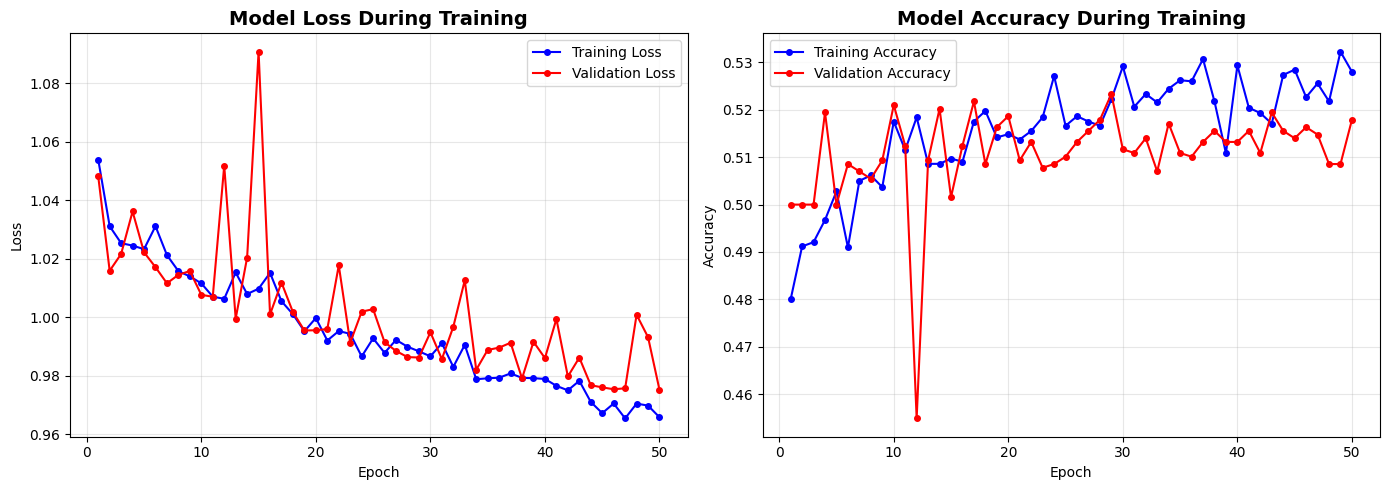

Model trained for 50 epochs
Best validation accuracy: 0.5233 at epoch 29
Final training accuracy: 0.5280
Final validation accuracy: 0.5179


In [29]:
# Get the number of epochs the model actually trained
num_epochs = len(history.history['loss'])
epochs = list(range(1, num_epochs + 1))

# Extract loss values for each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract accuracy values for each epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Now let's plot them
plt.figure(figsize=(14, 5))

# First plot: Loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(epochs, train_loss, 'b-o', label='Training Loss', markersize=4)
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss', markersize=4)
plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Second plot: Accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy', markersize=4)
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy', markersize=4)
plt.title('Model Accuracy During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some information
print(f"Model trained for {num_epochs} epochs")
print(f"Best validation accuracy: {max(val_acc):.4f} at epoch {val_acc.index(max(val_acc)) + 1}")
print(f"Final training accuracy: {train_acc[-1]:.4f}")
print(f"Final validation accuracy: {val_acc[-1]:.4f}")

In [30]:
print("Starting evaluation...")

# Get predictions
predictions_proba = model.predict(test_generator)
predictions = np.argmax(predictions_proba, axis=1)
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

print(f"Total test samples: {len(true_labels)}")

Starting evaluation...
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
Total test samples: 635


### Confusion Matrix

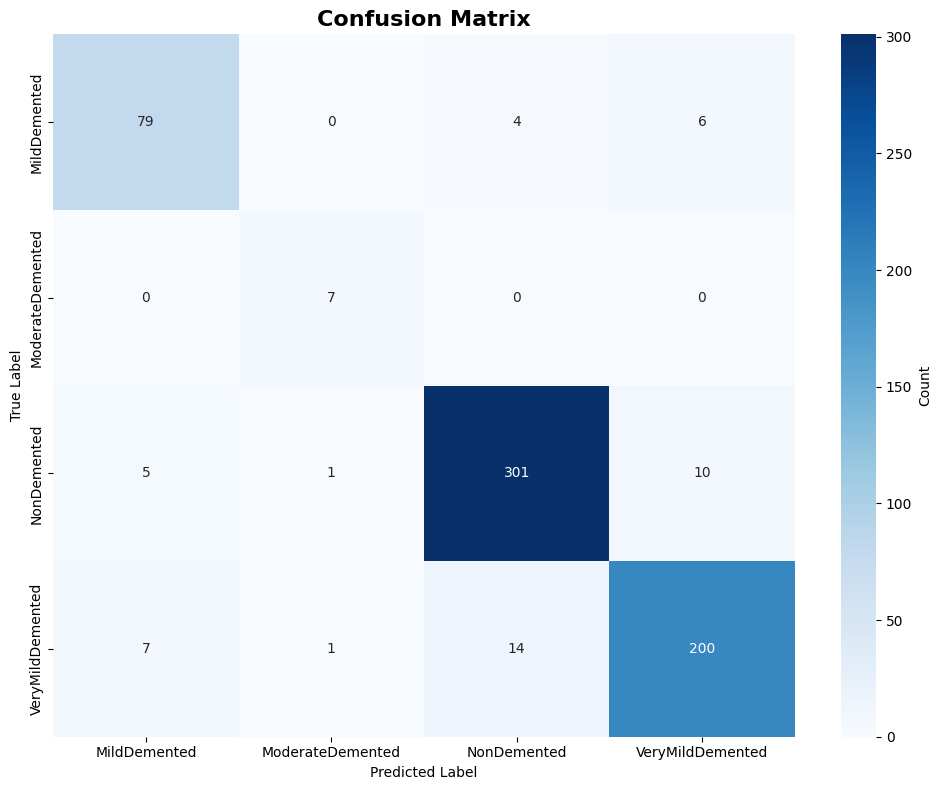

In [31]:
m = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Classification Report

In [32]:
print("\nClassification Report:")
print("="*70)
print(classification_report(true_labels, predictions, target_names=class_names))


Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00        89
ModerateDemented       0.00      0.00      0.00         7
     NonDemented       0.56      0.83      0.67       317
VeryMildDemented       0.41      0.31      0.35       222

        accuracy                           0.52       635
       macro avg       0.24      0.29      0.26       635
    weighted avg       0.43      0.52      0.46       635



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### ROC Curve

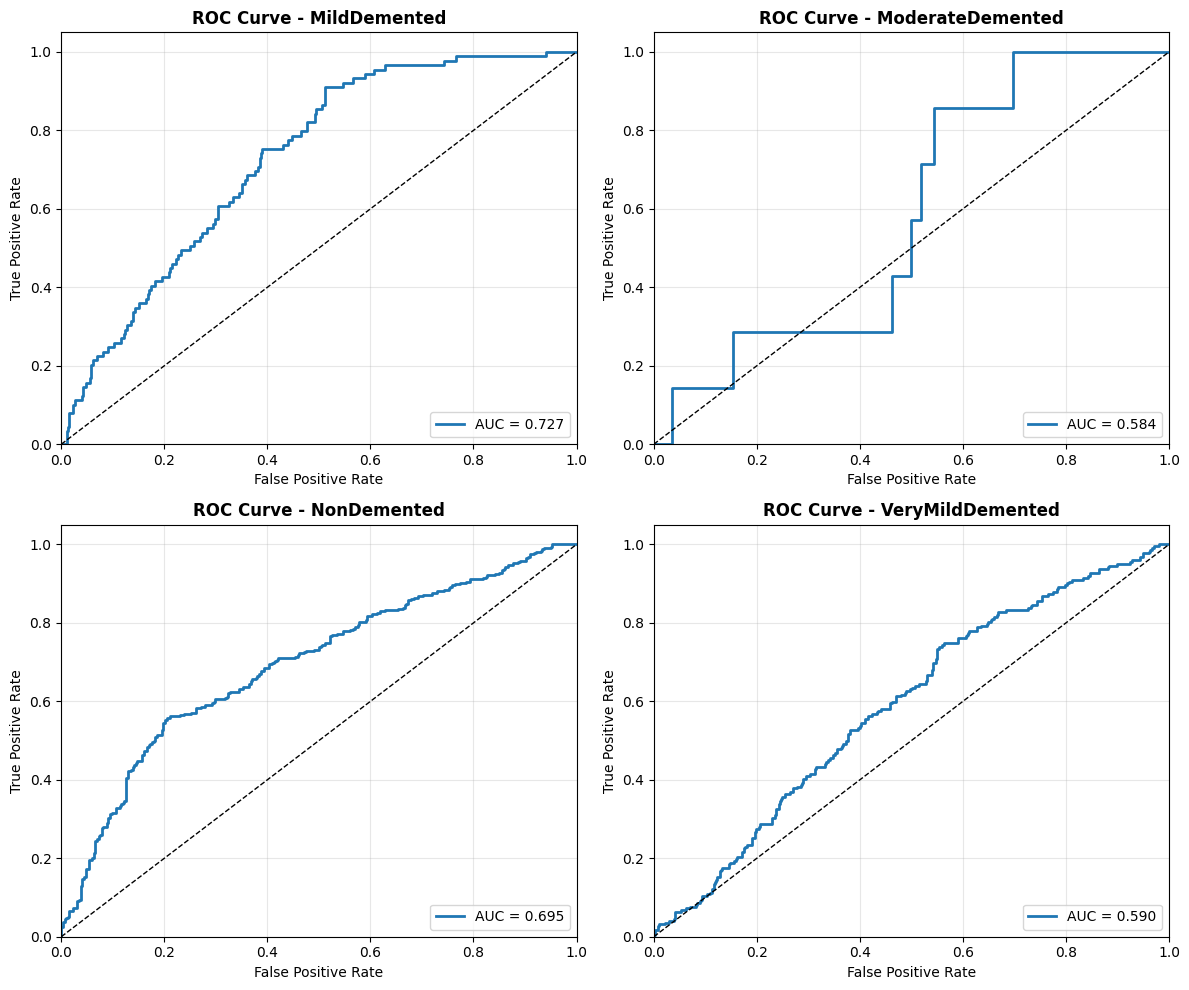

In [34]:
# Binarize labels for multi-class ROC
y_test_bin = label_binarize(true_labels, classes=range(len(class_names)))

plt.figure(figsize=(12, 10))

for i, class_name in enumerate(class_names):
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.subplot(2, 2, i+1)
    plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {class_name}', fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()